In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("/Users/viyankamoodley/Desktop/og_combined_data.csv")

In [3]:
data_copy = data.copy()



# i noticed the controls all had 2 spiral drawings compared to the parkinsons' patients, therefore I decided to split each control patient's data into two spirals based on Y threshold.
def split_spirals_by_y_and_create_id(data_copy, patient_id, y_threshold=5000):
    # Split into two spirals based on Y-coordinate threshold
    spiral1 = data_copy[data_copy['Y'] < y_threshold].copy()  # Spiral below the threshold
    spiral2 = data_copy[data_copy['Y'] >= y_threshold].copy()  # Spiral above the threshold
    
    # Create a unique spiral ID for each spiral
    spiral1['spiral_unique_id'] = f"{patient_id}_spiral_1"
    spiral2['spiral_unique_id'] = f"{patient_id}_spiral_2"
    
    return spiral1, spiral2

# applyinng the split to control patients only and create unique IDs
control_patient_ids = data_copy[data_copy['patient_group'] == 'Healthy']['patient_id'].unique()

spiral_data = []

for patient_id in control_patient_ids:
    patient_data = data_copy[data_copy['patient_id'] == patient_id]
    
    # split spirals for each control patient and create unique spiral ids
    spiral1, spiral2 = split_spirals_by_y_and_create_id(patient_data, patient_id)
    
    # add both spirals as separate entries
    spiral_data.append(spiral1)
    spiral_data.append(spiral2)

# joining data from all spirals into one df for controls
control_spiral_data = pd.concat(spiral_data)

# for parkinson's patients (who have only one spiral), assigning a unique spiral id
parkinsons_data = data_copy[data_copy['patient_group'] == 'Parkinsons'].copy()
parkinsons_data['spiral_unique_id'] = parkinsons_data['patient_id'] + '_spiral_1'

# joining control spiral data with parkinson's data into a final dataset
final_data_with_ids = pd.concat([control_spiral_data, parkinsons_data])


# making a copy of the data to removing all observations for patient_id 'T005'
filtered_data = final_data_with_ids[final_data_with_ids['patient_id'] != 'T005'].copy()

# making new col  'spiral_id' that gices a number for each spiral (1, 2, 3, etc.)
filtered_data['spiral_id'] = filtered_data.groupby('spiral_unique_id').ngroup() + 1

# dropping 'patient_id' and 'spiral_unique_id' cols
filtered_data = filtered_data.drop(columns=['patient_id', 'spiral_unique_id'])



In [4]:
filtered_data

,X,Y,timestamp,pen_state,azimuth,altitude,pressure,patient_group,spiral_id
0,5310,3728,1845198,1,3280,810,238,Healthy,1
1,5311,3726,1845206,1,3280,810,320,Healthy,1
2,5311,3726,1845213,1,3280,810,302,Healthy,1
3,5312,3725,1845221,1,3280,810,260,Healthy,1
4,5313,3725,1845228,1,3280,810,244,Healthy,1
...,...,...,...,...,...,...,...,...,...
121294,1922,9368,1890973561,1,2210,670,1287,Parkinsons,42
121295,1922,9368,1890973569,1,2210,670,1205,Parkinsons,42
121296,1922,9368,1890973576,1,2210,670,1071,Parkinsons,42
121297,1924,9368,1890973584,1,2210,670,809,Parkinsons,42


In [5]:
# resetting index and dropping the old one
filtered_data_reset = filtered_data.reset_index(drop=True)

# showing updated df without old index
filtered_data_reset


,X,Y,timestamp,pen_state,azimuth,altitude,pressure,patient_group,spiral_id
0,5310,3728,1845198,1,3280,810,238,Healthy,1
1,5311,3726,1845206,1,3280,810,320,Healthy,1
2,5311,3726,1845213,1,3280,810,302,Healthy,1
3,5312,3725,1845221,1,3280,810,260,Healthy,1
4,5313,3725,1845228,1,3280,810,244,Healthy,1
...,...,...,...,...,...,...,...,...,...
114631,1922,9368,1890973561,1,2210,670,1287,Parkinsons,42
114632,1922,9368,1890973569,1,2210,670,1205,Parkinsons,42
114633,1922,9368,1890973576,1,2210,670,1071,Parkinsons,42
114634,1924,9368,1890973584,1,2210,670,809,Parkinsons,42


In [6]:
df=filtered_data_reset.copy()
# to calculate euclidean distance between consecutive points
def calculate_distance(df):
    return np.sqrt((df['X'].diff())**2 + (df['Y'].diff())**2).fillna(0)

# to calculate velocity
def calculate_velocity(df, distance_col):
    velocity = distance_col / df['timestamp'].diff()
    return velocity.replace([np.inf, -np.inf], np.nan).fillna(0)

# to calculate acceleration
def calculate_acceleration(velocity_col, df):
    acceleration = velocity_col.diff() / df['timestamp'].diff()
    return acceleration.replace([np.inf, -np.inf], np.nan).fillna(0)

# to calculate jerk
def calculate_jerk(acceleration_col, df):
    jerk = acceleration_col.diff() / df['timestamp'].diff()
    return jerk.replace([np.inf, -np.inf], np.nan).fillna(0)

# to store the new feats
new_features = []

# processing each spiral by group
for spiral_id, group in df.groupby('spiral_id'):
    # distance, velocity, acceleration, and jerk
    group['distance'] = calculate_distance(group)
    group['velocity'] = calculate_velocity(group, group['distance'])
    group['acceleration'] = calculate_acceleration(group['velocity'], group)
    group['jerk'] = calculate_jerk(group['acceleration'], group)

    # getting mean and stdv for pressure, altitude, and azimuth
    mean_pressure = group['pressure'].mean()
    std_pressure = group['pressure'].std()
    
    mean_altitude = group['altitude'].mean()
    std_altitude = group['altitude'].std()
    
    mean_azimuth = group['azimuth'].mean()
    std_azimuth = group['azimuth'].std()

    # getting pen up and down times
    pen_up_time = group.loc[group['pen_state'] == 0, 'timestamp'].diff().sum()
    pen_down_time = group.loc[group['pen_state'] == 1, 'timestamp'].diff().sum()
    


    # for the stroke count (number of pen_state transitions)
    stroke_count = (group['pen_state'].diff() != 0).sum()

    # for the total distance drawn
    total_distance = group['distance'].sum()

    # getting mean velocity, acceleration, and jerk
    mean_velocity = group['velocity'].mean()
    mean_acceleration = group['acceleration'].mean()
    mean_jerk = group['jerk'].mean()

    # storing new feats in a dict
    features = {
        'spiral_id': spiral_id,
        'mean_pressure': mean_pressure,
        'std_pressure': std_pressure,
        'mean_altitude': mean_altitude,
        'std_altitude': std_altitude,
        'mean_azimuth': mean_azimuth,
        'std_azimuth': std_azimuth,
        'pen_up_time': pen_up_time,
        'pen_down_time': pen_down_time,
        'stroke_count': stroke_count,
        'total_distance': total_distance,
        'mean_velocity': mean_velocity,
        'mean_acceleration': mean_acceleration,
        'mean_jerk': mean_jerk,
        'patient_group': group['patient_group'].iloc[0]
    }
    
    # adding feats for spiral to list
    new_features.append(features)

# changing to df
features_df = pd.DataFrame(new_features)

# handle nas and infs
features_df = features_df.replace([np.inf, -np.inf], np.nan).fillna(0)

# inspecting new feats
features_df

,spiral_id,mean_pressure,std_pressure,mean_altitude,std_altitude,mean_azimuth,std_azimuth,pen_up_time,pen_down_time,stroke_count,total_distance,mean_velocity,mean_acceleration,mean_jerk,patient_group
0,1,1638.418687,261.767564,744.722222,41.519565,3372.313131,231.999248,2.300000e+01,1.486700e+04,2,19328.014477,1.304511,0.001616,0.000403,Healthy
1,2,932.246936,308.925301,808.892419,38.337958,1951.266455,118.343023,1.522000e+03,1.523400e+04,4,19173.015090,1.162766,0.001336,0.000329,Healthy
2,3,1014.970785,210.652806,748.940962,25.359261,3194.357882,824.106277,3.700000e+01,1.229600e+04,2,17422.461079,1.417467,0.001992,0.000439,Healthy
3,4,936.285307,281.949295,799.971469,31.603200,1673.128864,162.833223,1.023000e+03,1.477600e+04,2,18661.406380,1.185881,0.001395,0.000362,Healthy
4,5,1108.660030,111.279508,759.467397,42.277836,694.639124,1091.309697,2.300000e+01,1.507000e+04,2,16990.762929,1.130247,0.001539,0.000342,Healthy
5,6,888.637047,221.596059,745.128205,55.004776,1694.580018,174.139892,7.360000e+02,1.625700e+04,2,17410.503172,1.028660,0.001213,0.000311,Healthy
6,7,1094.413415,324.681721,604.107847,58.405004,311.836914,65.261294,1.891300e+04,2.024300e+04,4,17679.384192,1.033047,0.001601,0.000319,Healthy
7,8,918.837007,276.029963,728.533734,72.859735,1639.368737,125.550318,3.093000e+03,2.139800e+04,2,17903.707342,0.796083,0.000957,0.000238,Healthy
8,9,1448.352089,462.524178,810.330989,26.829848,3068.729830,902.225587,1.780000e+04,1.814600e+04,8,18436.804536,1.019327,0.001431,0.000310,Healthy
9,10,1476.021886,306.412925,789.654882,24.708124,1359.583333,223.029181,5.180000e+02,1.734000e+04,2,18333.264432,1.031021,0.001387,0.000318,Healthy


In [7]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spiral_id          42 non-null     int64  
 1   mean_pressure      42 non-null     float64
 2   std_pressure       42 non-null     float64
 3   mean_altitude      42 non-null     float64
 4   std_altitude       42 non-null     float64
 5   mean_azimuth       42 non-null     float64
 6   std_azimuth        42 non-null     float64
 7   pen_up_time        42 non-null     float64
 8   pen_down_time      42 non-null     float64
 9   stroke_count       42 non-null     int64  
 10  total_distance     42 non-null     float64
 11  mean_velocity      42 non-null     float64
 12  mean_acceleration  42 non-null     float64
 13  mean_jerk          42 non-null     float64
 14  patient_group      42 non-null     object 
dtypes: float64(12), int64(2), object(1)
memory usage: 5.1+ KB


# Modelling

Training Random Forest...
Accuracy for Random Forest: 0.7692307692307693
AUC-ROC for Random Forest: 0.8809523809523809
Precision for Random Forest = 0.75
Recall for Random Forest = 0.8571428571428571
F1 score for Random Forest = 0.8
Training Gradient Boosting...
Accuracy for Gradient Boosting: 0.6923076923076923
AUC-ROC for Gradient Boosting: 0.6904761904761905
Precision for Gradient Boosting = 0.7142857142857143
Recall for Gradient Boosting = 0.7142857142857143
F1 score for Gradient Boosting = 0.7142857142857143
Training SVM...
Accuracy for SVM: 0.7692307692307693
AUC-ROC for SVM: 0.8333333333333333
Precision for SVM = 1.0
Recall for SVM = 0.5714285714285714
F1 score for SVM = 0.7272727272727273


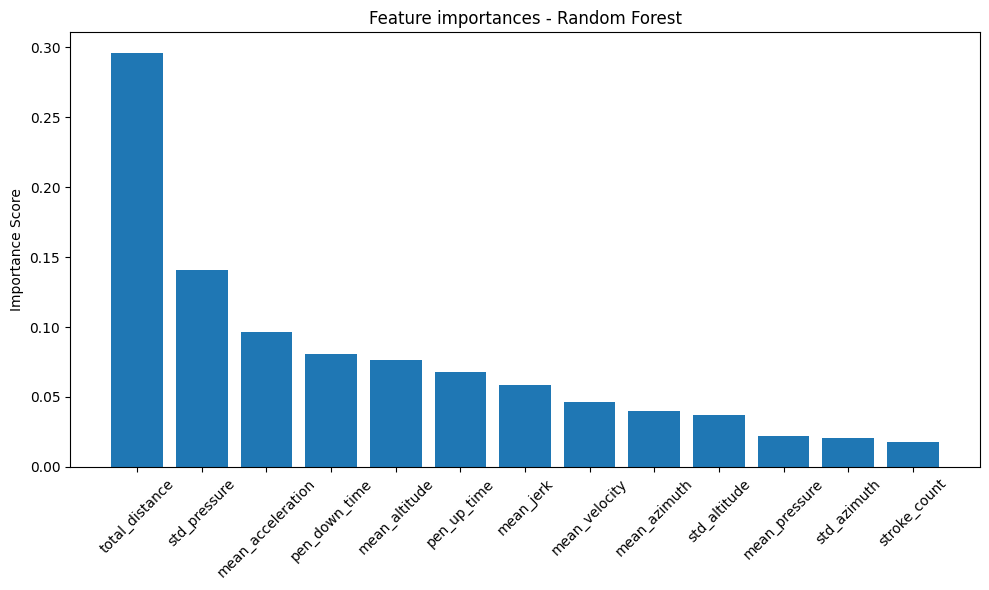

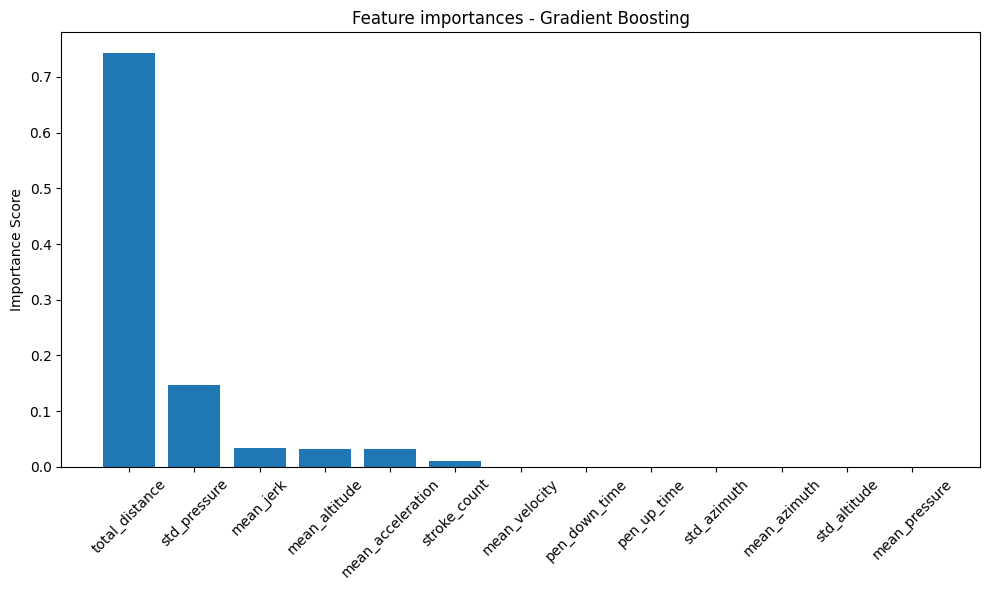

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


# preprocessing
features_df['patient_group'] = features_df['patient_group'].map({'Healthy': 0, 'Parkinsons': 1})

# splitting features and target
X = features_df.drop(columns=['spiral_id', 'patient_group'])  # dropping id and group cols
y = features_df['patient_group']

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=301, stratify=y)

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=301),
    'Gradient Boosting': GradientBoostingClassifier(random_state=301),
    'SVM': SVC(kernel='linear', probability=True, random_state=301)
}

# train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"Accuracy for {name}: {accuracy_score(y_test, y_pred)}")
    print(f"AUC-ROC for {name}: {roc_auc_score(y_test, y_proba)}")
    print(f"Precision for {name} = {precision_score(y_test, y_pred)}")
    print(f"Recall for {name} = {recall_score(y_test, y_pred)}")
    print(f"F1 score for {name} = {f1_score(y_test, y_pred)}")


# finding and plotting feat importances for tree-based models
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        indices = np.argsort(feature_importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature importances - {name}")
        plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
        plt.ylabel('Importance Score')
        plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=45)
        plt.tight_layout()
        plt.show()


In [9]:
from sklearn.feature_selection import RFE


svmm_linear = SVC(kernel='linear', probability=True, random_state=301)

# rfe for SVM
rfe = RFE(estimator=svmm_linear, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe_support = rfe.support_
rfe_ranking = rfe.ranking_

#  df for rfe results
rfe_results_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe_ranking,
    'Selected': rfe_support
})


In [10]:
rfe_results_df

,Feature,Ranking,Selected
0,mean_pressure,5,False
1,std_pressure,1,True
2,mean_altitude,6,False
3,std_altitude,8,False
4,mean_azimuth,1,True
5,std_azimuth,2,False
6,pen_up_time,1,True
7,pen_down_time,1,True
8,stroke_count,3,False
9,total_distance,1,True


In [12]:
#  feature importances from rf and gb
rf_model = models['Random Forest']
gb_model = models['Gradient Boosting']

# store the feature importances 
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

# get top 5 features from both models (based on feature importance)
top_rf_features = X.columns[np.argsort(rf_importances)[-5:]]
top_gb_features = X.columns[np.argsort(gb_importances)[-5:]]

# features selected by RFE (those marked as True)
rfe_selected_features = X.columns[rfe_support]

# combined the features from all approaches
selected_features = list(set(top_rf_features).union(set(top_gb_features)).union(set(rfe_selected_features)))

# showing the selected features
selected_features


['total_distance',
 'pen_down_time',
 'pen_up_time',
 'mean_altitude',
 'std_pressure',
 'mean_acceleration',
 'mean_azimuth',
 'mean_jerk']

In [15]:
top_gb_features

Index(['mean_acceleration', 'mean_altitude', 'mean_jerk', 'std_pressure',
       'total_distance'],
      dtype='object')

In [13]:

# feature selection on the og df (no scaling)
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

new_models = {
    'Random Forest': RandomForestClassifier(random_state=301),
    'Gradient Boosting': GradientBoostingClassifier(random_state=301),
    'SVM': SVC(kernel='linear', probability=True, random_state=301)  # Using linear kernel since it was used for RFE
}

# train and evaluate new models
new_results = {}
for name, model in new_models.items():
    model.fit(X_train_selected_scaled, y_train)
    y_predd = model.predict(X_test_selected_scaled)
    y_probaa = model.predict_proba(X_test_selected_scaled)[:, 1]
    print(f"Accuracy for {name}: {accuracy_score(y_test, y_predd)}")
    print(f"AUC-ROC for {name}: {roc_auc_score(y_test, y_probaa)}")
    print(f"Precision for {name} = {precision_score(y_test, y_predd)}")
    print(f"Recall for {name} = {recall_score(y_test, y_predd)}")
    print(f"F1 score for {name} = {f1_score(y_test, y_predd)}")
# show new results



Accuracy for Random Forest: 0.8461538461538461
AUC-ROC for Random Forest: 0.9523809523809524
Precision for Random Forest = 0.8571428571428571
Recall for Random Forest = 0.8571428571428571
F1 score for Random Forest = 0.8571428571428571
Accuracy for Gradient Boosting: 0.6923076923076923
AUC-ROC for Gradient Boosting: 0.7142857142857143
Precision for Gradient Boosting = 0.7142857142857143
Recall for Gradient Boosting = 0.7142857142857143
F1 score for Gradient Boosting = 0.7142857142857143
Accuracy for SVM: 0.7692307692307693
AUC-ROC for SVM: 0.8333333333333334
Precision for SVM = 1.0
Recall for SVM = 0.5714285714285714
F1 score for SVM = 0.7272727272727273
